In [1]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import jieba
import jieba.analyse as analyse
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns 

## 加载数据

In [2]:
train_data = pd.read_csv('./data/train.csv', sep="###__###", names=['id', 'age', 'gender', 'education', 'query'], encoding='utf-8')
test_data = pd.read_csv('./data/test.csv', sep="###__###", names=['id', 'query'], encoding='utf-8')

In [3]:
train_test_data = pd.read_csv('./data/train_test.csv', encoding='utf-8')
train_test_data

,id,age,gender,education,query
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场"
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,旅顺公交\t辽宁阜新车牌\tbaidu\tk715


## 数据状态

In [4]:
print("训练集大小:{}, 测试集大小:{}".format(len(train_data), len(test_data)))

训练集大小:100000, 测试集大小:100000


训练集和测试集大小一样，都是十万条数据。

In [5]:
train_data.head(5)

,id,age,gender,education,query
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只..."
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...


In [6]:
train_data.isna().sum()

id           0
age          0
gender       0
education    0
query        0
dtype: int64

In [7]:
test_data.head(5)

,id,query
0,ED89D43B9F602F96D96C25255F7C228C,陈学冬将出的作品\t刘昊然与谭松韵\t211学校的分数线\t谁唱的味道好听\t吻戏是真吻还是...
1,83C3B7B4AAF8074655A8079F561A76D6,e的0.0052次方\tqq怎么快速提现\t绝色倾城飞烟\t马克思主义基本原理概论\t康世恩...
2,CA9F675A024FB2353849350A35CF8B0F,黑暗文\tlpl夏季赛\t大富豪电玩城\t英雄联盟之电竞称王\t手机怎么扫描手机上的二维码\...
3,DE45B5C4E57AAEBCF3FDFA2A774093BF,中秋水库钓鱼\t鱼竿\t用蚯蚓钓鱼怎样调漂\t传统钓\t3号鱼钩\t鲫鱼汤的做法大全\t鱼饵...
4,406A681FB3DF81EC0E561796AE50AE50,号码吉凶\t退休干部死后配偶\t郫县有哪些大学\t胜利油田属于中石化还是中石油\t苏珊米勒狮...


In [8]:
test_data.isna().sum()

id       0
query    0
dtype: int64

## Query字段处理
### query次数<br/>
列名为`query_count`

In [9]:
train_data['query_count'] = train_data['query'].apply(lambda x: len(x.split('\t')))
train_data.head()

,id,age,gender,education,query,query_count
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117


### query字符总长度
一个汉字和字母长度为1，列名为`query_length`

In [10]:
train_data['query_length'] = train_data['query'].apply(lambda x: len(x))
train_data['query_length'] = train_data['query_length'] - train_data['query_count'] -1
train_data.head()

,id,age,gender,education,query,query_count,query_length
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010


### query平均字符长度
一个汉字和字母长度为1，列名为`query_length_aver`

In [11]:
train_data['query_length_aver'] = round(train_data['query_length'] / train_data['query_count'], 2)
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63


### query空格数
列名为`query_space`

In [12]:
train_query_split = train_data['query'].apply(lambda x: x.split('\t'))
type(train_query_split)

pandas.core.series.Series

In [13]:
train_data['query_space'] = train_query_split.map(lambda query_list: sum([query.count(' ') for query in query_list]))
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6


### query逗号数
列名为`query_comma`

In [14]:
train_data['query_comma'] = train_query_split.map(lambda query_list: sum([query.count(',')+query.count('，') for query in query_list]))
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space,query_comma
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8,3
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12,12
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3,0
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7,2
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6,2


### query字母数
将连续出现三个字母及以上的视为一个，例如`如何ab在abc之后的abcd`的字母数2。列名为`query_en_3`

In [15]:
# 英文计数
def en_count(list_node, char_len=3):
    en_cnt = 0
    each_en_cnt = 0
    for c in list_node:
        # 判断是否字母
        if c >= 'A' and c <= 'z':
            each_en_cnt += 1
            # 字母长度达到3个，算一个单词
            if each_en_cnt == char_len:
                en_cnt += 1
        else:
            each_en_cnt = 0
    return en_cnt
en_count("如何ab在abc之后的abcd", 3)

2

In [16]:
train_data['query_en_3'] = train_query_split.map(lambda query_list: sum([en_count(query, 3) for query in query_list]))
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space,query_comma,query_en_3
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8,3,74
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12,12,2
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3,0,3
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7,2,8
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6,2,17


In [17]:
train_data['query_en_4'] = train_query_split.map(lambda query_list: sum([en_count(query, 4) for query in query_list]))
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space,query_comma,query_en_3,query_en_4
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8,3,74,45
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12,12,2,0
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3,0,3,2
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7,2,8,6
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6,2,17,13


In [18]:
train_data['query_en_5'] = train_query_split.map(lambda query_list: sum([en_count(query, 5) for query in query_list]))
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space,query_comma,query_en_3,query_en_4,query_en_5
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8,3,74,45,29
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12,12,2,0,0
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3,0,3,2,1
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7,2,8,6,1
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6,2,17,13,3


## age维度分析

| 字段       | 说明                                                         |
| ---------- | ------------------------------------------------------------ |
| ID         | 加密后的ID                                                   |
| Age        | 0：未知年龄; 1：0-18岁; 2：19-23岁; 3：24-30岁; 4：31-40岁; 5：41-50岁; 6： 51-999岁 |
| Gender     | 0：未知1：男性2：女性                                        |
| Education  | 0：未知学历; 1：博士; 2：硕士; 3：大学生; 4：高中; 5：初中; 6：小学 |
| Query List | 搜索词列表                                                   |

### 年龄层分布

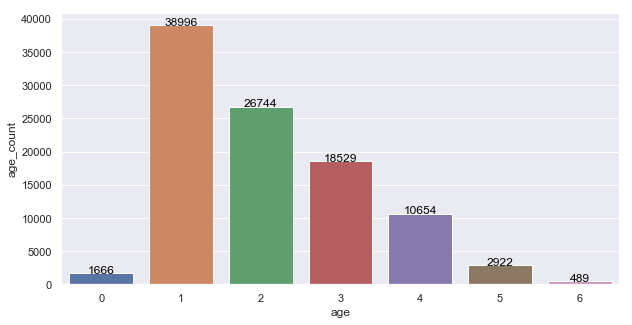

In [19]:
sns.set(style="darkgrid")
plt.subplots(figsize=(10,5))
age_stat = train_data.groupby(by=['age'])['age'].agg({"age_count":np.size})
age_stat = age_stat.reset_index()
g = sns.barplot(x='age', y='age_count', data=age_stat)
for index,row in age_stat.iterrows():
    # 在柱状图上绘制个年龄层的数量
    g.text(row.age, row.age_count, row.age_count, color="black", ha="center")

随着年龄层的增加，用户越少。<br/>
### 每个年龄层性别分布<br/>
各年龄层的不同性别的人数

In [20]:
age_gender_stat = train_data.groupby(by=['age', 'gender'])['gender'].agg({"gender_count":np.size})
age_gender_pect = age_gender_stat.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2)).reset_index()['gender_count']
age_gender_stat = age_gender_stat.reset_index()
age_gender_stat['gender_pect'] = age_gender_pect
age_gender_stat.head()

,age,gender,gender_count,gender_pect
0,0,0,989,59.36
1,0,1,412,24.73
2,0,2,265,15.91
3,1,0,533,1.37
4,1,1,24369,62.49


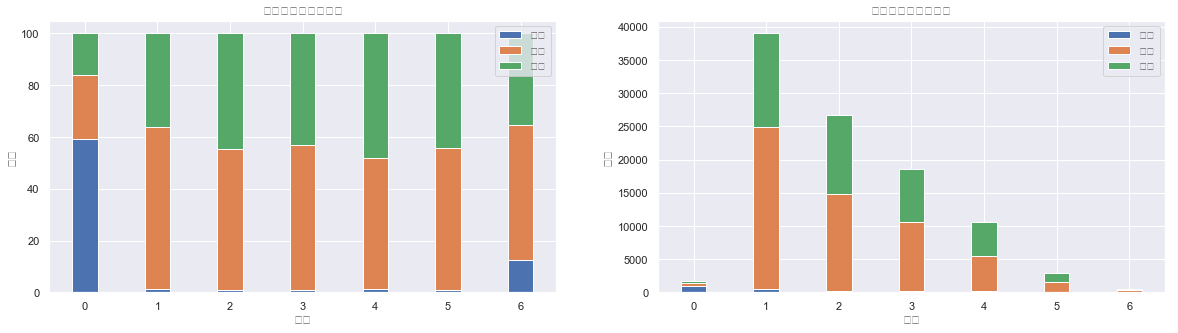

In [21]:
N = 7
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt_conf = ((1, (0, 1, 2), 'gender_pect', '比例'), (2, (0, 1, 2), 'gender_count', '计数'))

plt.figure(figsize=(20,5))

for conf in plt_conf:
    plt.subplot(120 + conf[0])
    i = 1
    bottom_data = None
    for gender in conf[1]:
        gender_data = tuple(age_gender_stat[age_gender_stat.gender == gender][conf[2]])
        locals()['p'+str(i)] = plt.bar(ind, gender_data, width, bottom=bottom_data)
        if bottom_data is None:
            bottom_data = np.array(gender_data)
        else:
            bottom_data = bottom_data + np.array(gender_data)
        i += 1
            
    plt.ylabel('性别')
    plt.title('年龄性别{}分布图'.format(conf[3]))
    plt.xlabel('年龄')
    plt.legend((p1[0], p2[0], p3[0]), ('未知', '男性', '女性'))
    
plt.show()

### 每个年龄层学历分布

In [22]:
age_edu_stat = train_data.groupby(by=['age', 'education'])['education'].agg({"education_count":np.size})
age_edu_pect = age_edu_stat.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2)).reset_index()['education_count']
age_edu_stat = age_edu_stat.reset_index()
age_edu_stat['education_pect'] = age_edu_pect
line = pd.DataFrame({"age": 0, "education": 1, "education_count": 0, "education_pect": 0}, index=[1])
age_edu_stat = pd.concat([age_edu_stat.iloc[:1], line, age_edu_stat.iloc[1:]])
age_edu_stat.head()

,age,education,education_count,education_pect
0,0,0,103,6.18
1,0,1,0,0.00
1,0,2,2,0.12
2,0,3,46,2.76
3,0,4,58,3.48


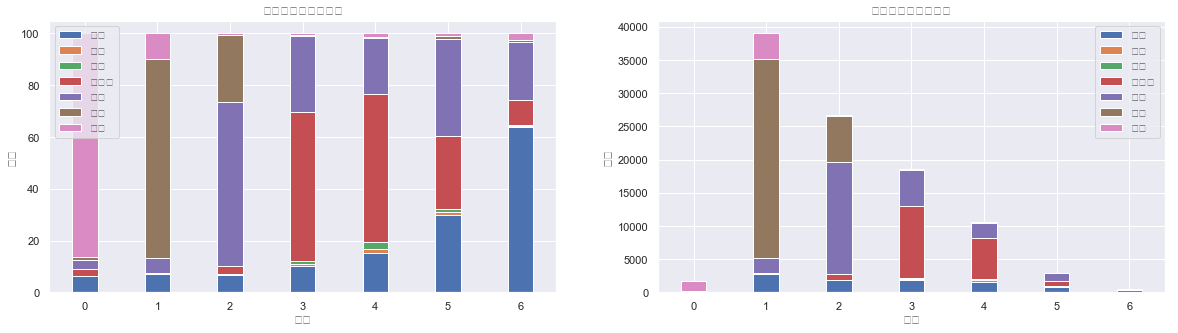

In [23]:
N = 7
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt_conf = ((1, (0, 1, 2, 3, 4, 5, 6), 'education_pect', '比例'), (2, (0, 1, 2, 3, 4, 5, 6), 'education_count', '计数'))
plt.figure(figsize=(20,5))

for conf in plt_conf:
    plt.subplot(120 + conf[0])
    
    bottom_data = None
    i = 1
    for education in conf[1]:
      
        education_data = tuple(age_edu_stat[age_edu_stat.education == education][conf[2]])
        locals()['p'+str(i)] = plt.bar(ind, education_data, width, bottom=bottom_data)
        if bottom_data is None:
            bottom_data = np.array(education_data)
        else:
            bottom_data = bottom_data + np.array(education_data)
        i += 1
            
    plt.ylabel('学历')
    plt.title('年龄性别{}分布图'.format(conf[3]))
    plt.xlabel('年龄')
    plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0]), ('未知', '博士', '硕士', '大学生', '高中', '初中', '小学'))
    
plt.show()

### 每个年龄层平均Query次数

In [24]:
train_data.head()

,id,age,gender,education,query,query_count,query_length,query_length_aver,query_space,query_comma,query_en_3,query_en_4,query_en_5
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生\t中财网首页 财经\thttp://pan.baidu.com/s/1pl...,275,2378,8.65,8,3,74,45,29
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场\t我只...",186,1642,8.83,12,12,2,0,0
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石之泪耳机\t盘锦到沈阳\t旅顺公交\t辽宁阜新车牌\tbaidu\tk715\tk716...,104,595,5.72,3,0,3,2,1
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,最受欢迎狗狗排行榜\t舶怎么读\t场景描 写范例\t三维绘图软件\t枣和酸奶能一起吃吗\t好...,173,1123,6.49,7,2,8,6,1
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症能自愈吗\t太太万岁叶舒心去没去美国\t干槽症\t右眼皮下面一直跳是怎么回事\t麦当劳...,117,1010,8.63,6,2,17,13,3


In [25]:
age_query_count_stat = train_data[['age', 'query_count']].groupby(by=('age'))['query_count'].agg({"age_query_count": np.mean})
age_query_count_stat = age_query_count_stat.reset_index()
age_query_count_stat['log_age_query_count'] = train_data[['query_count']].apply(lambda x: np.log(x))
age_query_count_stat.head()

,age,age_query_count,log_age_query_count
0,0,145.129052,5.616771
1,1,141.184583,5.225747
2,2,146.756768,4.644391
3,3,142.843704,5.153292
4,4,139.096677,4.762174


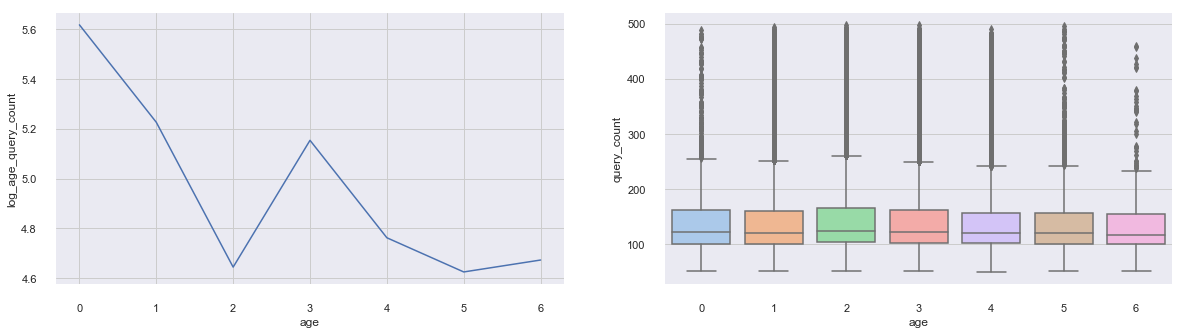

In [26]:
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="log_age_query_count", data=age_query_count_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_count", data=train_data)
sns.despine(offset=10, trim=True)

## 每个年龄层平均query长度

In [27]:
age_query_length_stat = train_data[['age', 'query_length']].groupby(by=('age'))['query_length'].agg({"age_query_length": np.mean})
age_query_length_stat = age_query_length_stat.reset_index()
age_query_length_stat.head()

,age,age_query_length
0,0,1094.281513
1,1,1068.569366
2,2,1128.693763
3,3,1089.838577
4,4,1067.134316


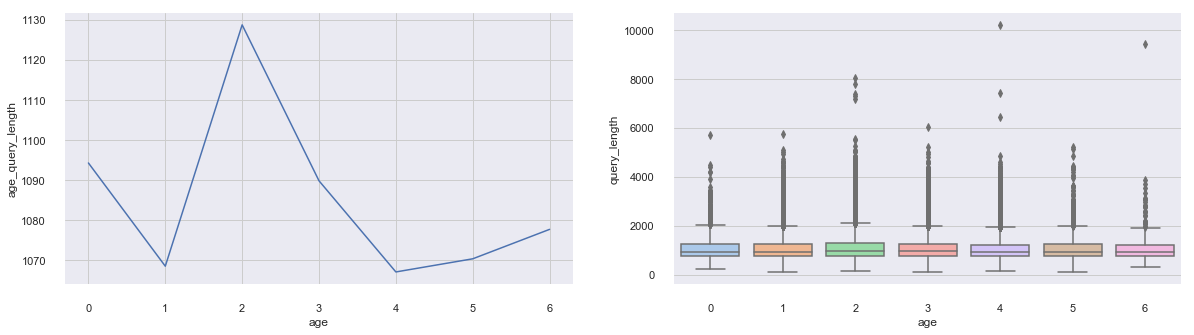

In [28]:
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_length", data=age_query_length_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_length", data=train_data)
sns.despine(offset=10, trim=True)

### 每个年龄层在每人平均query长度的平均query长度

In [29]:
age_aver_query_length_stat = train_data[['age', 'query_length_aver']].groupby(by=('age'))['query_length_aver'].agg({"age_aver_query_length": np.mean})
age_aver_query_length_stat = age_aver_query_length_stat.reset_index()
age_aver_query_length_stat.head()

,age,age_aver_query_length
0,0,7.576495
1,1,7.604390
2,2,7.725690
3,3,7.663624
4,4,7.699116


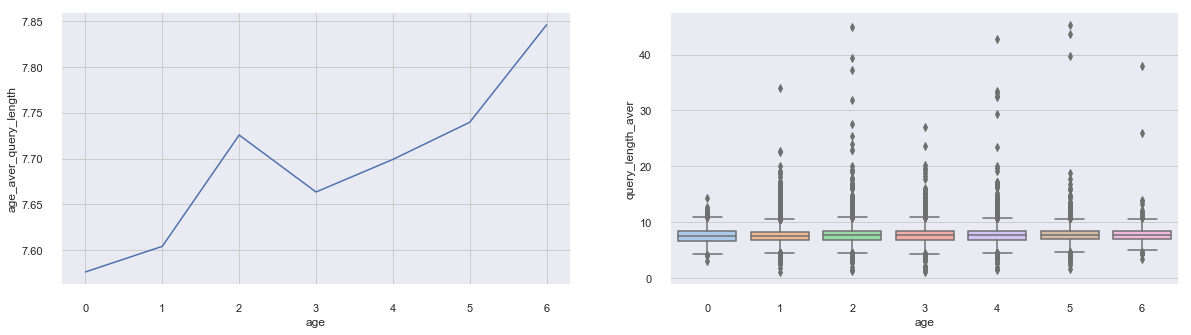

In [30]:
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_aver_query_length", data=age_aver_query_length_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_length_aver", data=train_data)
sns.despine(offset=10, trim=True)

### 每个年龄层平均使用空格数

In [31]:
age_query_space_stat = train_data[['age', 'query_space']].groupby(by=('age'))['query_space'].agg({"age_query_sapce": np.mean})
age_query_space_stat = age_query_space_stat.reset_index()
age_query_space_stat.head()

,age,age_query_sapce
0,0,4.492197
1,1,4.715253
2,2,4.843778
3,3,4.727130
4,4,5.895157


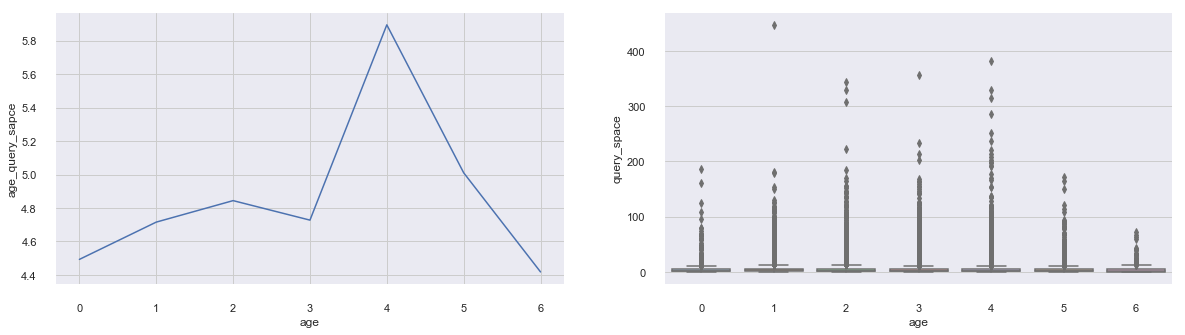

In [32]:
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_sapce", data=age_query_space_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_space", data=train_data)
sns.despine(offset=10, trim=True)

## 每个年龄层平均使用逗号数

In [33]:
age_query_comma_stat = train_data[['age', 'query_comma']].groupby(by=('age'))['query_comma'].agg({"age_query_comma": np.mean})
age_query_comma_stat = age_query_comma_stat.reset_index()
age_query_comma_stat.head()

,age,age_query_comma
0,0,1.905762
1,1,1.710740
2,2,1.770528
3,3,1.668897
4,4,2.020462


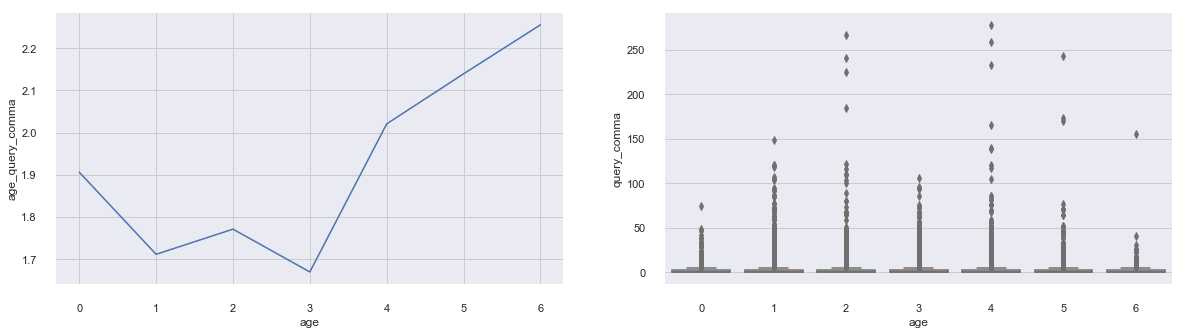

In [34]:
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_comma", data=age_query_comma_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_comma", data=train_data)
sns.despine(offset=10, trim=True)

## 每个年龄层平均使用英文字符_3

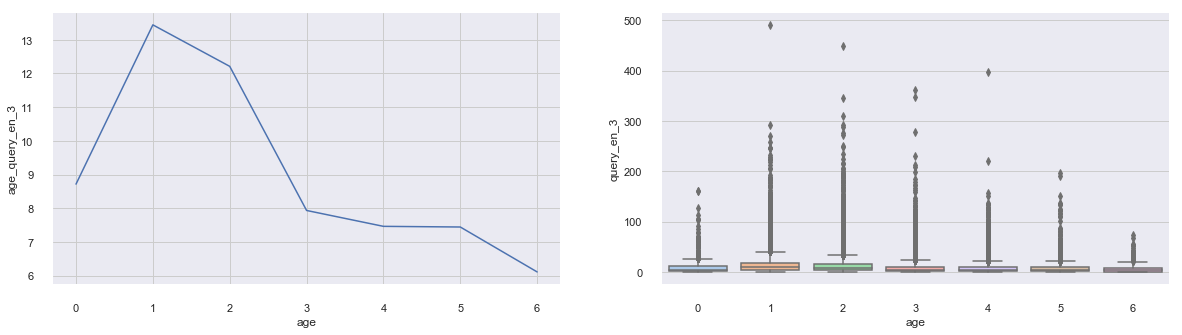

In [35]:
age_query_en_3_stat = train_data[['age', 'query_en_3']].groupby(by=('age'))['query_en_3'].agg({"age_query_en_3": np.mean})
age_query_en_3_stat = age_query_en_3_stat.reset_index()
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_en_3", data=age_query_en_3_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_en_3", data=train_data)
sns.despine(offset=10, trim=True)

## 每个年龄层平均使用英文字符_4

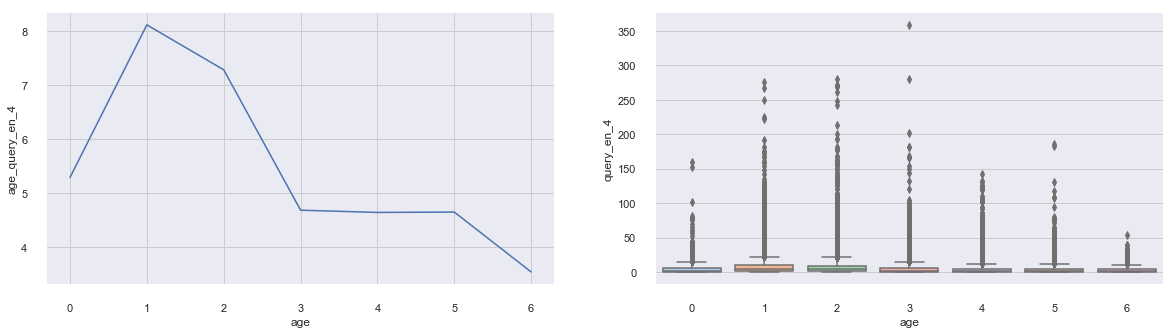

In [36]:
age_query_en_4_stat = train_data[['age', 'query_en_4']].groupby(by=('age'))['query_en_4'].agg({"age_query_en_4": np.mean})
age_query_en_4_stat = age_query_en_4_stat.reset_index()
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_en_4", data=age_query_en_4_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_en_4", data=train_data)
sns.despine(offset=10, trim=True)

## 每个年龄层平均使用英文字符_5

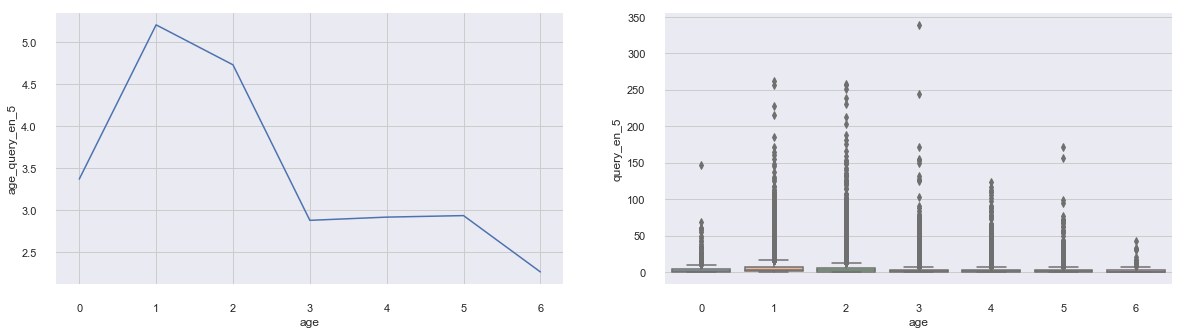

In [37]:
age_query_en_5_stat = train_data[['age', 'query_en_5']].groupby(by=('age'))['query_en_5'].agg({"age_query_en_5": np.mean})
age_query_en_5_stat = age_query_en_5_stat.reset_index()
plt.subplots(figsize=(20,5))
sns.set(style="darkgrid")

plt.subplot(121)
sns.lineplot(x="age", y="age_query_en_5", data=age_query_en_5_stat)

plt.subplot(122)
sns.set(style="ticks", palette="pastel")
sns.boxplot(x="age", y="query_en_5", data=train_data)
sns.despine(offset=10, trim=True)

### 不同年龄层词频统计

In [49]:
# 将分词后的数据存入list
def query_list_cut(content):
    segment = []
    for line in content:
        try:
            segs = jieba.lcut(line)
            for seg in segs:
                if len(seg) > 1 and seg != "\r\n":
                    segment.append(seg)
        except:
            print(line)
            continue
    return segment

In [39]:
train_test_data

,id,age,gender,education,query
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和双沟\t女生
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"广州厨宝烤箱\t世情薄,人情恶,雨送黄昏花易落,晓风干,泪痕\t厦门酒店用品批发市场"
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,旅顺公交\t辽宁阜新车牌\tbaidu\tk715


In [56]:
# age=0的分词
age_0_words_df = pd.DataFrame(columns=['age', 'segment'])
# 7
age_2_content = []
for _, value in train_test_data[train_test_data['age'] == 2]['query'].apply(lambda x: x.split('\t')).iteritems():
    age_2_content += value
age_2_segment = query_list_cut(age_2_content)
age_0_words_df['segment'] = age_2_segment
age_0_words_df['age'] = 2

age_0_words_df.head()

,age,segment
0,2,广州
1,2,厨宝
2,2,烤箱
3,2,世情
4,2,人情


In [60]:
for i in range(7):
    locals()['age_'+str(i)+'_words_df'] = pd.DataFrame(columns=['age', 'segment'])
    locals()['age_'+str(i)+'_content'] = []
    for _, value in train_data[train_data['age'] == i]['query'].apply(lambda x: x.split('\t')).iteritems():
        locals()['age_'+str(i)+'_content'] += value
    locals()['age_'+str(i)+'_segment'] = query_list_cut(locals()['age_'+str(i)+'_content'])
    locals()['age_'+str(i)+'_words_df']['segment'] = locals()['age_'+str(i)+'_segment']
    locals()['age_'+str(i)+'_words_df']['age'] = i

In [65]:
# 保存age 0~6的csv
for i in range(7):
    locals()['age_'+str(i)+'_words_df'].to_csv('./data/age_{}_words.csv'.format(i),index=False, encoding='utf-8')

### 去除停用词

In [82]:
# 加载停用词字典
stop_words = pd.read_csv("./data/stopwords.txt", names=['stopword'], quoting=3, encoding='utf-8')
# 将words里面的停用词去除
for i in range(7):
    locals()['age_'+str(i)+'_words_df'] = locals()['age_'+str(i)+'_words_df'][~locals()['age_'+str(i)+'_words_df'].segment.isin(stop_words.stopword)]

### 各年龄段前100个词频差集
- 0~18 词频差集

In [130]:
age_1_words_stat_top100 = age_1_words_stat[:100]
age_1_words_stat_top100 = age_1_words_stat_top100[~age_1_words_stat_top100.segment.isin(age_2_words_stat[:100].segment)]
age_1_words_stat_top100 = age_1_words_stat_top100[~age_1_words_stat_top100.segment.isin(age_3_words_stat[:100].segment)]
age_1_words_stat_top100 = age_1_words_stat_top100[~age_1_words_stat_top100.segment.isin(age_4_words_stat[:100].segment)]
age_1_words_stat_top100 = age_1_words_stat_top100[~age_1_words_stat_top100.segment.isin(age_5_words_stat[:100].segment)]
age_1_words_stat_top100 = age_1_words_stat_top100[~age_1_words_stat_top100.segment.isin(age_6_words_stat[:100].segment)]
age_1_words_stat_top100

,segment,count
31,动漫,21813
36,少女,19824
50,答案,15228
53,翻译,15116
55,男生,14615
63,cf,12781
67,学校,11939
68,网名,11936
69,邪恶,11747
72,天天,11588


In [ ]:
lines=df.content.values.tolist()
content = "".join(lines)
print("  ".join(analyse.extract_tags(content, topK=30, withWeight=False, allowPOS=())))

- 19~23词频差集

In [131]:
age_2_words_stat_top100 = age_2_words_stat[:100]
age_2_words_stat_top100 = age_2_words_stat_top100[~age_2_words_stat_top100.segment.isin(age_1_words_stat[:100].segment)]
age_2_words_stat_top100 = age_2_words_stat_top100[~age_2_words_stat_top100.segment.isin(age_3_words_stat[:100].segment)]
age_2_words_stat_top100 = age_2_words_stat_top100[~age_2_words_stat_top100.segment.isin(age_4_words_stat[:100].segment)]
age_2_words_stat_top100 = age_2_words_stat_top100[~age_2_words_stat_top100.segment.isin(age_5_words_stat[:100].segment)]
age_2_words_stat_top100 = age_2_words_stat_top100[~age_2_words_stat_top100.segment.isin(age_6_words_stat[:100].segment)]
age_2_words_stat_top100

,segment,count
41,考试,11640
62,考研,9347
68,教师,8493
82,书包,7816
97,适合,6658


- 24~30词频差集

In [132]:
age_3_words_stat_top100 = age_3_words_stat[:100]
age_3_words_stat_top100 = age_3_words_stat_top100[~age_3_words_stat_top100.segment.isin(age_1_words_stat[:100].segment)]
age_3_words_stat_top100 = age_3_words_stat_top100[~age_3_words_stat_top100.segment.isin(age_2_words_stat[:100].segment)]
age_3_words_stat_top100 = age_3_words_stat_top100[~age_3_words_stat_top100.segment.isin(age_4_words_stat[:100].segment)]
age_3_words_stat_top100 = age_3_words_stat_top100[~age_3_words_stat_top100.segment.isin(age_5_words_stat[:100].segment)]
age_3_words_stat_top100 = age_3_words_stat_top100[~age_3_words_stat_top100.segment.isin(age_6_words_stat[:100].segment)]
age_3_words_stat_top100

,segment,count
78,银行,4737
80,婴儿,4710
83,胎儿,4597
85,牌子,4519
88,检查,4467
91,信息,4436
92,贷款,4375
96,肚子,4289
98,幼儿园,4268


- 31~40词频差集

In [133]:
age_4_words_stat_top100 = age_4_words_stat[:100]
age_4_words_stat_top100 = age_4_words_stat_top100[~age_4_words_stat_top100.segment.isin(age_1_words_stat[:100].segment)]
age_4_words_stat_top100 = age_4_words_stat_top100[~age_4_words_stat_top100.segment.isin(age_2_words_stat[:100].segment)]
age_4_words_stat_top100 = age_4_words_stat_top100[~age_4_words_stat_top100.segment.isin(age_3_words_stat[:100].segment)]
age_4_words_stat_top100 = age_4_words_stat_top100[~age_4_words_stat_top100.segment.isin(age_5_words_stat[:100].segment)]
age_4_words_stat_top100 = age_4_words_stat_top100[~age_4_words_stat_top100.segment.isin(age_6_words_stat[:100].segment)]
age_4_words_stat_top100

,segment,count
52,小学,3740
55,拼音,3433
61,儿童,3231
89,老师,2588
99,奥运会,2397


- 41~50词频差集

In [136]:
age_5_words_stat_top100 = age_5_words_stat[:100]
age_5_words_stat_top100 = age_5_words_stat_top100[~age_5_words_stat_top100.segment.isin(age_1_words_stat[:100].segment)]
age_5_words_stat_top100 = age_5_words_stat_top100[~age_5_words_stat_top100.segment.isin(age_2_words_stat[:100].segment)]
age_5_words_stat_top100 = age_5_words_stat_top100[~age_5_words_stat_top100.segment.isin(age_3_words_stat[:100].segment)]
age_5_words_stat_top100 = age_5_words_stat_top100[~age_5_words_stat_top100.segment.isin(age_4_words_stat[:100].segment)]
age_5_words_stat_top100 = age_5_words_stat_top100[~age_5_words_stat_top100.segment.isin(age_6_words_stat[:100].segment)]
age_5_words_stat_top100

,segment,count
48,广场,1028
79,生肖,774
98,美国,661


- 51~99词频差集

In [138]:
age_6_words_stat_top100 = age_6_words_stat[:100]
age_6_words_stat_top100 = age_6_words_stat_top100[~age_6_words_stat_top100.segment.isin(age_1_words_stat[:100].segment)]
age_6_words_stat_top100 = age_6_words_stat_top100[~age_6_words_stat_top100.segment.isin(age_2_words_stat[:100].segment)]
age_6_words_stat_top100 = age_6_words_stat_top100[~age_6_words_stat_top100.segment.isin(age_3_words_stat[:100].segment)]
age_6_words_stat_top100 = age_6_words_stat_top100[~age_6_words_stat_top100.segment.isin(age_4_words_stat[:100].segment)]
age_6_words_stat_top100 = age_6_words_stat_top100[~age_6_words_stat_top100.segment.isin(age_5_words_stat[:100].segment)]
age_6_words_stat_top100

,segment,count
19,农村,271
30,1978,221
48,二手房,181
54,武汉,167
57,参军,162
62,国家,155
63,胶囊,153
72,王宝强,140
75,糖尿病,138
77,导航,136


In [3]:
jieba.lcut("因吹斯汀")

['因吹', '斯汀']